##**HOMEWORK 07**
###**Autoencoders**
### IANNWTF
###Group 02

In [2]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from IPython import display
import time 
# print(tf.__version__)


#**Load data**

In [57]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

Let's explore the data by doing some usefull prints.

In [58]:
print(train_images.shape, test_images.shape)
# Let's check the normalized images 
print(type(train_images))
print(f'Minimun = {np.min(train_images[0])}, \nMaximun = {np.max(train_images[0])}\n')
# print(train_images[0])

(60000, 28, 28) (10000, 28, 28)
<class 'numpy.ndarray'>
Minimun = 0, 
Maximun = 255



##**Normalization and Input pipeline**

We will use the folowwing function to normalize, create our input pipeline and save some normalized images for later visualization.

In [67]:
def input_pipeline(images, labels):
  # 1. Normalize the images to be between 0 and 1
  train_images = tf.image.convert_image_dtype(images, tf.float32)
  # 2. Create a tf.dataset from a train tensor images
  train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
  # expand the dimensions of the images.
  train_dataset = train_dataset.map(lambda img : tf.cast(tf.expand_dims(img,-1), tf.float32))

  # 3. Save normalized images for later visualization
  test_images_plot =  train_dataset
  test_images_plot = test_images_plot.shuffle(buffer_size=128)

  # reshape the labels 
  labels=labels.reshape((-1))
  # 4. we will need the labels for visualization of the embeddings
  train_dataset_labels = tf.data.Dataset.from_tensor_slices(labels)
  # we want the labels to be onehot encoded
  train_dataset_labels = train_dataset_labels.map(lambda t : tf.one_hot(t, 10))

  # zip together input and labels for visualization of embeddings later on
  labeled_data = tf.data.Dataset.zip((train_dataset, train_dataset_labels))
  labeled_data = labeled_data.shuffle(buffer_size=128)
  labeled_data = labeled_data.batch(64)
  labeled_data = labeled_data.prefetch(tf.data.experimental.AUTOTUNE)
  
  # futher preprocessing 
  train_dataset = train_dataset.shuffle(buffer_size=128)
  train_dataset = train_dataset.batch(64)
  train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


  return train_dataset, test_images_plot, labeled_data

In [68]:
# Only images for training 
train_dataset, _ , _ = input_pipeline(train_images, train_labels)

# Images and lables for test and visualization
test_dataset, test_images_plot, labeled_data = input_pipeline(test_images, test_labels)

# check the sizes and dimensions of the images
for i in train_dataset:
  print(f'min = {np.min(i)} \nmax = {np.max(i)} \nshape = {i.shape}, \ntype = {i.dtype}')
  break

min = 0.0 
max = 1.0 
shape = (64, 28, 28, 1), 
type = <dtype: 'float32'>


#**1. Building the Convolutional Autoencoder**

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

# THE ENCODER
# Using two layers for reducing the size with a normal convolutional layer and dropout in between
class Encoder(Model):
  def __init__(self):
    super(Encoder, self).__init__()
    self.reduce1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3,
                                          strides=(2,2),
                                          padding = 'same',
                                          activation='relu',
                                          input_shape=(28,28,1)
                                          )
    self.conv = tf.keras.layers.Conv2D(filters=32, kernel_size=3,
                                          strides=(1,1),
                                          padding = 'same',
                                          activation='relu')
    self.dropout = tf.keras.layers.Dropout(rate=0.3)
    self.reduce2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                          strides=(2,2),
                                          padding = 'same',
                                          activation='relu')
    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.out = tf.keras.layers.Dense(10, activation='relu')

  @tf.function
  def call(self, x):
    x = self.reduce1(x)
    x = self.conv(x)
    x = self.dropout(x)
    x = self.reduce2(x)
    x = self.global_pool(x)
    x = self.out(x)
    return x

In [15]:
# THE DECODER
# using two normal convolutional layers and a dropout layer with two upsamling layers in between.
class Decoder(Model):
  def __init__(self):
    super(Decoder, self).__init__()
    #input shape is (10)
    self.first = tf.keras.layers.Dense(49, activation='relu')
    #shape is (49)
    self.reshape = tf.keras.layers.Reshape((7,7,1))
    #shape is now (7,7,1)

    self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, 
                                          padding = 'same',
                                          activation='relu'
                                          )
    self.upsampling1 = tf.keras.layers.UpSampling2D((2,2))
    
    self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, 
                                          padding = 'same',
                                          activation='relu'
                                          )
    self.dropout = tf.keras.layers.Dropout(rate=0.5)
    self.conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                          padding = 'same',
                                          activation='relu'
                                          )
    self.upsampling2 = tf.keras.layers.UpSampling2D((2,2))
    self.out = tf.keras.layers.Conv2D(filters=1, kernel_size=3,
                                          padding = 'same',
                                          activation='sigmoid'
                                          )
  
  @tf.function
  def call(self, x):
    x = self.first(x)
    x = self.reshape(x)
    x = self.conv1(x)
    x = self.upsampling1(x)
    x = self.conv2(x)
    x = self.dropout(x)
    x = self.conv3(x)
    x = self.upsampling2(x)
    x = self.out(x)
    return x

In [16]:
# THE AUTOENCODER
class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  @tf.function
  def call(self, x):
    x = self.encoder(x)
    decoder = self.decoder(x)
    return decoder

###**Training the Convolutional Autoencoder**

In [17]:
# train and test as usual, 
# just with the loss of input against prediction instead of target against prediction
# also we no longer have an accuraccy and are only using (and plotting) the loss

def train_step(model, input, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(input, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data
  test_loss_aggregator = []

  for input in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(input, prediction)
    test_loss_aggregator.append(sample_test_loss.numpy())

  test_loss = np.mean(test_loss_aggregator)

  return test_loss

In [18]:
# Plot training and test loss.
def plot_loss(train_losses,test_losses):
  plt.figure()
  line1, = plt.plot(train_losses)
  line2, = plt.plot(test_losses)
  plt.title(f'Total test loss: {np.min(test_losses)}')
  plt.xlabel("Training steps")
  plt.ylabel("Loss")
  plt.legend((line1,line2),("training","test"))
  plt.show()

### **Training model**

Epoch: _10


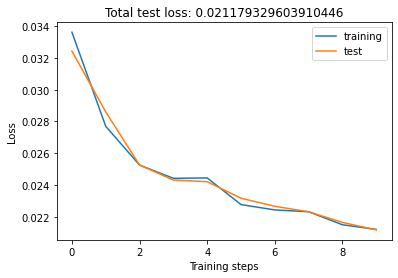


This training took: 1 minutes and 59.265565395355225 seconds.


In [19]:
import time
tf.keras.backend.clear_session()
### Hyperparameters
num_epochs = 10
learning_rate = 0.001
running_average_factor = 0.95

# Set the time
start = time.time()

# Initialize the model.
autoencoder = Autoencoder()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.MeanSquaredError()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []

# We train for num_epochs epochs.
for epoch in range(1, num_epochs + 1):

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    # training 
    running_average = 0
    for input in train_dataset:
        train_loss = train_step(autoencoder, input, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    # testing
    test_loss = test(autoencoder, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)

    # Clear after new epoch
    display.clear_output(wait=False)
    print(f'Epoch: _{epoch}')
    plot_loss(train_losses, test_losses)
    

# Keep track of the time 
end = time.time()
duration = end - start

print(f'\nThis training took: {int (duration / 60)} minutes and {(duration % 60)} seconds.')

In [20]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  23946     
_________________________________________________________________
decoder (Decoder)            multiple                  56860     
Total params: 80,806
Trainable params: 80,806
Non-trainable params: 0
_________________________________________________________________


##**Convolutional Autoencoder Visualization**

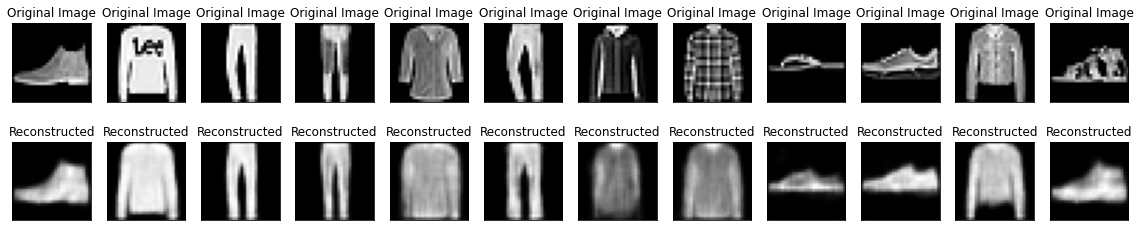

In [30]:
# Amount of images we want to display
n = 12
plt.figure(figsize=(20, 4))
count = 0

for i, img in enumerate(test_images_plot):
  # Display original image
  count+=1
  ax = plt.subplot(2, n, i + 1)
  ax.set_title("Original Image")
  plt.imshow(tf.reshape(img, [28,28]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Display reconstructed image
  encoder = autoencoder.encoder(tf.reshape(img, [-1,28,28,1]))
  decoder = autoencoder.decoder(encoder)

  ax = plt.subplot(2, n, i + 1 + n)
  ax.set_title("Reconstructed")
  plt.imshow(tf.reshape(decoder, [28,28]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  if count==n:
    break


###**Latent Space Convolutional Autoencoder**

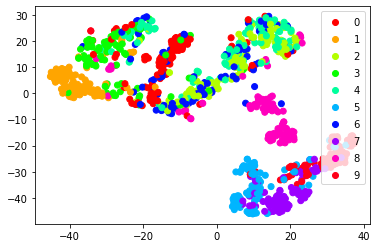

0=top 1=trouser 2=pullover 3=dress 4=coat 5=sandal 6=shirt 7=sneaker 8=bag 9=boot


In [82]:
from sklearn.manifold import TSNE
plt.hsv() 

# first we take 1000 image-label pairs from the test_data_set (thats all that is done in the for-loop)
exampleEmbeddings=[]
exampleLabels=[]
for (input,target) in labeled_data:
  for array in autoencoder.encoder(input):
    exampleEmbeddings.append(array)
    if len(exampleEmbeddings)>=1000:
      break
  for lab in target: 
    exampleLabels.append(lab)
    if len(exampleLabels)>=1000:
      break
  if len(exampleEmbeddings)>=1000:
    break

# transform from one-hot-code to class integers
newlabs=np.argmax(exampleLabels, axis = 1)
# apply TSNE
tsne_embeds=TSNE().fit_transform(exampleEmbeddings)
# and plot the points in a scatter plot
scatter=plt.scatter(tsne_embeds[:,0],tsne_embeds[:,1],c=newlabs)
plt.legend(*scatter.legend_elements(prop="colors"))
plt.show()
print('0=top', '1=trouser', '2=pullover', '3=dress', '4=coat', '5=sandal', '6=shirt', '7=sneaker', '8=bag', '9=boot')

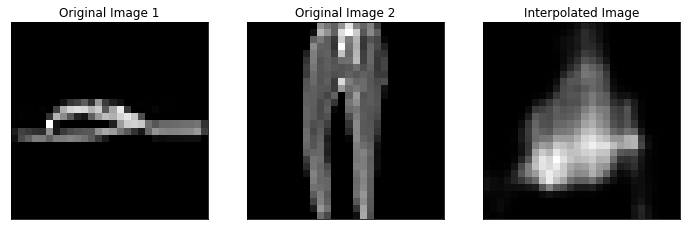

In [74]:
plt.figure(figsize=(12, 7))
encoder1=None
for i, img in enumerate(test_images_plot):
  if encoder1==None:
    encoder1 = autoencoder.encoder(tf.reshape(img, [-1,28,28,1]))

    ax = plt.subplot( 1,3, 1)
    ax.set_title("Original Image 1")
    plt.imshow(tf.reshape(img, [28,28]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  else:
    ax = plt.subplot(1,3, 2)
    ax.set_title("Original Image 2")
    plt.imshow(tf.reshape(img, [28,28]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    encoder2 = autoencoder.encoder(tf.reshape(img, [-1,28,28,1]))
    final_encoder=(encoder1+encoder2)/2

    decoder = autoencoder.decoder(final_encoder)

    ax = plt.subplot( 1,3, 3)
    ax.set_title("Interpolated Image")
    plt.imshow(tf.reshape(decoder, [28,28]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    break

#**2. Convolutional Variational AutoEncoder (CVAE)**
Now we will implement a convolutional variational autoencoder, also known as CVAE. For this purpose, we will be follow [this](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb#scrollTo=2M7LmLtGEMQJ) tensorflow guide which is a great source for understanding how the CVAE handles sampling and computes the losses.

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

# THE Variational ENCODER
# we use the same architecture as before, just without a drop-out-layer and with a different output-dimension
class VEncoder(Model):
  def __init__(self, l_dimension):
    super(VEncoder, self).__init__()
    # This will allow us to easily costumize the size of our embedding 
    self.l_dimension = l_dimension
    
    self.reduce1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3,
                                          strides=(2,2),
                                          padding = 'same',
                                          activation='relu',
                                          input_shape=(28,28,1)
                                          )
    self.conv = tf.keras.layers.Conv2D(filters=32, kernel_size=3,
                                          strides=(1,1),
                                          padding = 'same',
                                          activation='relu')
    self.reduce2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                          strides=(2,2),
                                          padding = 'same',
                                          activation='relu')
    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()

    # Here we want to have double the parameters in order to calculate the mean and the log-variance
    # Additionally, no activation for this layer
    self.out = tf.keras.layers.Dense(units = 2 * l_dimension)

  @tf.function
  def call(self, x):
    x = self.reduce1(x)
    x = self.conv(x)
    x = self.reduce2(x)
    x = self.global_pool(x)
    x = self.out(x)
    return x

In [35]:
# THE V DECODER
# Again we use the same architecture as in the normal decoder
class VDecoder(Model):
  def __init__(self, l_dimension):
    super(VDecoder, self).__init__()
    # This will us to easily costumize the size of our embedding 
    self.l_dimension = l_dimension
    
    #input shape is (10)
    self.first = tf.keras.layers.Dense(49, activation='relu')
    #shape is (49)
    self.reshape = tf.keras.layers.Reshape((7,7,1))
    #shape is now (7,7,1)

    self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3,
                                          padding = 'same',
                                          activation='relu'
                                          )
    self.upsampling1 = tf.keras.layers.UpSampling2D((2,2))
    
    self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, 
                                          padding = 'same',
                                          activation='relu'
                                          )
    self.dropout = tf.keras.layers.Dropout(rate=0.5)
    self.conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                          padding = 'same',
                                          activation='relu'
                                          )
    self.upsampling2 = tf.keras.layers.UpSampling2D((2,2))
    # No activation for this layer
    self.out = tf.keras.layers.Conv2D(filters=1, kernel_size=3,
                                          padding = 'same',
                                          )
  @tf.function
  def call(self, x):
    x = self.first(x)
    x = self.reshape(x)
    x = self.conv1(x)
    x = self.upsampling1(x)
    x = self.conv2(x)
    x = self.dropout(x)
    x = self.conv3(x)
    x = self.upsampling2(x)
    x = self.out(x)
    return x

In [36]:
# THE VARIATIONAL AUTOENCODER
class VAutoencoder(Model):
  def __init__(self, l_dimension):
    super(VAutoencoder, self).__init__()
    # This will us to easily costumize the size of our embedding 
    self.l_dimension = l_dimension
    # Initialize VEncoder and VDecoder 
    self.encoder = VEncoder(l_dimension)
    self.decoder = VDecoder(l_dimension)

  # The following functions will allow us to define the connections 
  # in our network architecture (as in the tf.cvae example)

  # returns an image generated for a given embedding (eps).
  # if eps is None, choose a random embedding
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  # use the encoder to transform an image to the variational embedding
  def encode(self, x):
    # Compute mean and logvar from Dense layer from encoder
    # the network-output has the form [mean0,mean1,...mean9,logvar0,...,logvar9] so we have to split
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  # Modify a sample (given by the encoder) by changing it randomly, so that it can be used by the decoder 
  def reparameterize(self, mean, logvar):
    # obtain a random vector of the same size as the decoder-input
    eps = tf.random.normal(shape=mean.shape)
    # the input for the decoder will be the mean + a random value (logvar defines how big this random value gets)
    return eps * tf.exp(logvar * .5) + mean

  # Generate an image for the embedding z
  def decode(self, z, apply_sigmoid=False):
    # takes and decodes sample z
    logits = self.decoder(z)
    if apply_sigmoid: # we only want to apply sigmoid when generating images for visualization, not when computing losses for training
      probs = tf.sigmoid(logits)
      return probs
    return logits

###**Training the Convolutional Variational AutoEncoder (CVAE)**

In [37]:
# This penalizes, if sample deviates from a gaussion normal with a given mean and logvar
def log_normal_pdf(sample, mean, logvar, raxis=1):
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + tf.math.log(2. * np.pi)),
      axis=raxis)


def compute_loss(model, x):
  # we first obtain the embedding generated from the encoder
  mean, logvar = model.encode(x)
  # modify it randomly
  z = model.reparameterize(mean, logvar)
  # and obtain the image generated by the 
  x_logit = model.decode(z)
  # cross-entropy between the original image and the generated image
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  # giving cross_ent the right dimension
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  # loss for how much the embedding deviates from a gaussian normal
  logpz = log_normal_pdf(z, 0., 0.)
  # but ignore the part that was specified by the embedding
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


def train_step(model, x, optimizer):
  # the same training as always, only with a custom loss function, that also does the prediction
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

###**Convolutional Variational AutoEncoder Visualization**
Here we create some useful functions that will allow us to visualize both some images during training process and the losses.

In [38]:
# Take a number of samples to visualize from a batch of the dataset
def num_images(n_img):
  for test_batch in train_dataset.take(1):
    test_sample = test_batch[0:n_img, :, :, :]
    return test_sample

# Function for visualization of the images during training process as in the tf guide
def visualize_images(model, epoch, test_sample, row, col):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)

  fig = plt.figure(figsize=(6, 6))
  # Visualize each sample image
  for i in range(row * col):
    img = predictions[i, :, :, 0]
    plt.subplot(row, col, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  plt.show()


# Plot training and test loss.
def plot_losses(train_losses, test_losses):
  plt.figure()
  line1, = plt.plot(train_losses)
  line2, = plt.plot(test_losses)
  plt.title(f'Total test loss: {test_losses[-1]}')
  plt.xlabel("Training steps")
  plt.ylabel("Loss")
  plt.legend((line1, line2),("training","test"))
  plt.show()

###**Training and Visualizing the Convolutional Varietional AutoEncoder**

Epoch: _10


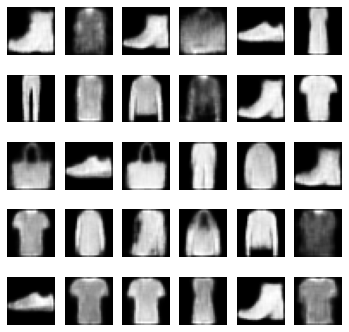

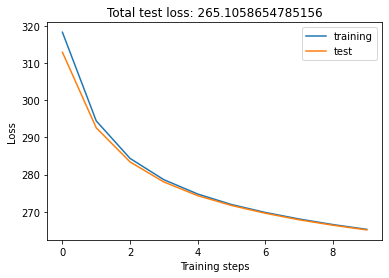


This training took: 3 minutes and 31.454648971557617 seconds.


In [39]:
tf.keras.backend.clear_session()
# set the dimensionality of the latent space 
l_dimension = 10
# Hyperparameters
epochs = 10
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)

model_cvae = VAutoencoder(l_dimension)

train_losses = []
test_losses = []
# We use keras metrics Mean to compute loss as specified in the tf cvae guide
loss = tf.keras.metrics.Mean()

start = time.time()

# We train for the number of epochs
for epoch in range(1, epochs + 1):

  # Training 
  for train_x in train_dataset:
    # Perform a training step and take the mean
    loss(train_step(model_cvae, train_x, optimizer))
  train_loss = loss.result()
  train_losses.append(train_loss)
  
  # Testing
  for test_x in test_dataset:
    # Compute loss and take the mean
    loss(compute_loss(model_cvae, test_x))
  test_loss = loss.result()
  test_losses.append(test_loss)
  
  # Clear after new epoch
  display.clear_output(wait=False)
  print(f'Epoch: _{epoch}')
  # Visualize some of the images using the function we created above
  visualize_images(model_cvae, epoch, num_images(30), 5,6)
  # Visualize losses 
  plot_loss(train_losses, test_losses) 
  
end = time.time()
duration = end - start
print(f'\nThis training took: {int (duration / 60)} minutes and {(duration % 60)} seconds.')

###**Latent Space CVAE**

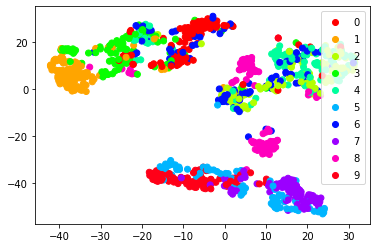

0=top 1=trouser 2=pullover 3=dress 4=coat 5=sandal 6=shirt 7=sneaker 8=bag 9=boot


In [85]:
from sklearn.manifold import TSNE
plt.hsv() 

# first we take 1000 image-label pairs from the test_data_set (thats all that is done in the for-loop)
exampleEmbeddings=[]
exampleLabels=[]
for (input,target) in labeled_data:
  for array in model_cvae.encoder(input):
    exampleEmbeddings.append(array)
    if len(exampleEmbeddings)>=1000:
      break
  for lab in target: 
    exampleLabels.append(lab)
    if len(exampleLabels)>=1000:
      break
  if len(exampleEmbeddings)>=1000:
    break

# transform from one-hot-code to class integers
newlabs=np.argmax(exampleLabels, axis = 1)
# apply TSNE
tsne_embeds=TSNE().fit_transform(exampleEmbeddings)
# and plot the points in a scatter plot
scatter=plt.scatter(tsne_embeds[:,0],tsne_embeds[:,1],c=newlabs)
plt.legend(*scatter.legend_elements(prop="colors"))
plt.show()
print('0=top', '1=trouser', '2=pullover', '3=dress', '4=coat', '5=sandal', '6=shirt', '7=sneaker', '8=bag', '9=boot')

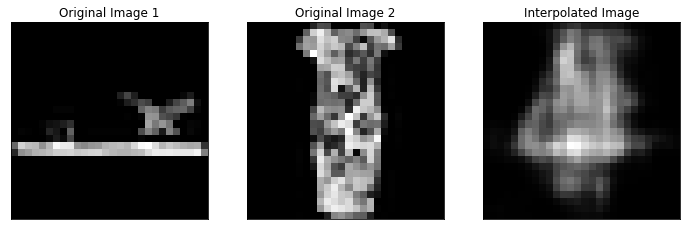

In [75]:
plt.figure(figsize=(12, 7))
encoder1=None
for i, img in enumerate(test_images_plot):
  if encoder1==None:
    mean,logvar = model_cvae.encode(tf.reshape(img, [-1,28,28,1]))
    encoder1=model_cvae.reparameterize(mean,logvar)

    ax = plt.subplot( 1,3, 1)
    ax.set_title("Original Image 1")
    plt.imshow(tf.reshape(img, [28,28]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  else:
    ax = plt.subplot(1,3, 2)
    ax.set_title("Original Image 2")
    plt.imshow(tf.reshape(img, [28,28]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    mean,logvar = model_cvae.encode(tf.reshape(img, [-1,28,28,1]))
    encoder2=model_cvae.reparameterize(mean,logvar)
    final_encoder=(encoder1+encoder2)/2

    decoder = model_cvae.sample(final_encoder)

    ax = plt.subplot(1,3, 3)
    ax.set_title("Interpolated Image")
    plt.imshow(tf.reshape(decoder, [28,28]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    break

###**Latent Space Analysis**

As we can see from the process above, the results for the normal autoencoder are as expected: a chaotic latent space with similar classes close to each other or even overlapping. When interpolating, we only get a blur interpolated image for between the classes, again as expected. An image lacking of a meaningful structure and harder to recognize as part of the two original images.
On the contrary, we can see that with the CVAE, the classes tend to be more centered and less spread. 
However, we are surprised that the results seem to be quite similar for the Variational Autoencoder: We expected to see a more structured Latent Space diagram and a more meaningful interpolated image.